# 3. Experimentieren

Basierend auf diesen Daten können nun weitere Experimente zur Analyse und Visualisierung dieser Daten durchgeführt werden.
Im Folgenden sind zwei Experimente implementiert:

1. Boxplot zur Darstellung der Partei-Haltungen zur Elternzeit
2. Barchart zur Darstellung der Parteien mit den meisten Abweichlern


Für beide Experimente müssen zuerst die Daten geladen werden:


In [1]:
import json

filename = "nationalrat_raw.json"
candidates = json.load(open(filename, encoding="utf-8"))

# Elternzeit


In [2]:
import pandas as pd # Für tabellenartige Daten
import seaborn as sns # Für die Visualisierung
import matplotlib.pyplot as plt # Für die Visualisierung

# Daten in ein Pandas DataFrame umwandeln (für die bessere Handhabung)
df = pd.DataFrame(candidates)
answer_data = []
fragen_objekte = df.head(1)['answers'][0] # Array aus allen Fragen
print(fragen_objekte)
frage = fragen_objekte[0]['text'] # Erste Frage

[{'questionId': '32218', 'value': 75, 'text': 'Soll die bezahlte Elternzeit von heute 14 Wochen Mutterschafts- und zwei Wochen Vaterschaftsurlaub ausgebaut werden? [BePart-Frage]'}, {'questionId': '32261', 'value': 75, 'text': 'Eine Volksinitiative möchte die Fernseh- und Radiogebühren reduzieren (200 Franken pro Haushalt, Abgabenbefreiung von Unternehmen). Unterstützen Sie dieses Anliegen?'}, {'questionId': '32214', 'value': 0, 'text': 'Befürworten Sie eine Erhöhung des Rentenalters (z.B. auf 67 Jahre)?'}, {'questionId': '32223', 'value': 0, 'text': 'Sollen in Zukunft bei Pandemien die Möglichkeiten des Bundesrats zur Einschränkung des Privat- und Wirtschaftslebens stärker begrenzt werden?'}, {'questionId': '32224', 'value': 25, 'text': 'Soll der Bund die Kompetenz zur Festlegung des Spitalangebots erhalten (nationale Spitalplanung bzgl. Standorte und Leistungsangebot)?'}, {'questionId': '32225', 'value': 25, 'text': 'Gemäss dem Konzept der integrativen Schule werden Kinder mit Lernsc

In [3]:
for idx, row in df.iterrows():
    for answer in row["answers"]: # Iteriere über alle Antworten
       if answer["questionId"] == "32215": # Definiere die Frage, die du visualisieren möchtest
        answer_data.append({ # Fügt die Daten zu jedem Kandidierenden in einen Array
            "id": row["id"],
            "firstname": row["firstname"],
            "lastname": row["lastname"],
            "partyAbbreviation": row["partyAbbreviation"],
            "partyColor": row["partyColor"],
            "questionId": answer["questionId"],
            "answer": int(answer["value"])
            })
answer_df = pd.DataFrame(answer_data)
print(answer_df)

         id  firstname      lastname partyAbbreviation partyColor questionId  \
0     56233    Antonio         Abate         Die Mitte    #D6862B      32215   
1     53622      Björn        Abbühl               JFS    #3872B5      32215   
2     53564    Andrea   Abderhalden                FDP    #3872B5      32215   
3     55509     Yasmin     Abdullahi              JGLP    #C4C43D      32215   
4     56874    Jérémie         Abegg                JM    #D6862B      32215   
...     ...        ...           ...               ...        ...        ...   
4958  59180     Nicole      Zwimpfer                SD    #9D9D9D      32215   
4959  56383      Lukas         Zwyer                JM    #D6862B      32215   
4960  54688    Dominic       Zwyssig                JA    #84B547      32215   
4961  54805     Ursula        Zybach                SP    #F0554D      32215   
4962  53495  Dominique       Zygmont               FDP    #3872B5      32215   

      answer  
0         75  
1        

In [4]:
# Lösche Parteien mit weniger als 75 Kandidierenden
party_counts = answer_df['partyAbbreviation'].value_counts() # Zähle die Anzahl der Kandidierenden pro Partei
parties_to_keep = party_counts[party_counts > 75].index # Definiere die Parteien, die mehr als 75 Kandidierende haben
filtered_answer_df = answer_df[answer_df['partyAbbreviation'].isin(parties_to_keep)] # Löscht die Kandidierenden, die nicht in den definierten Parteien sind

/tmp/ipykernel_162125/3292253296.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='partyAbbreviation', y='answer', data=filtered_answer_df, palette='Set2', showfliers=False)


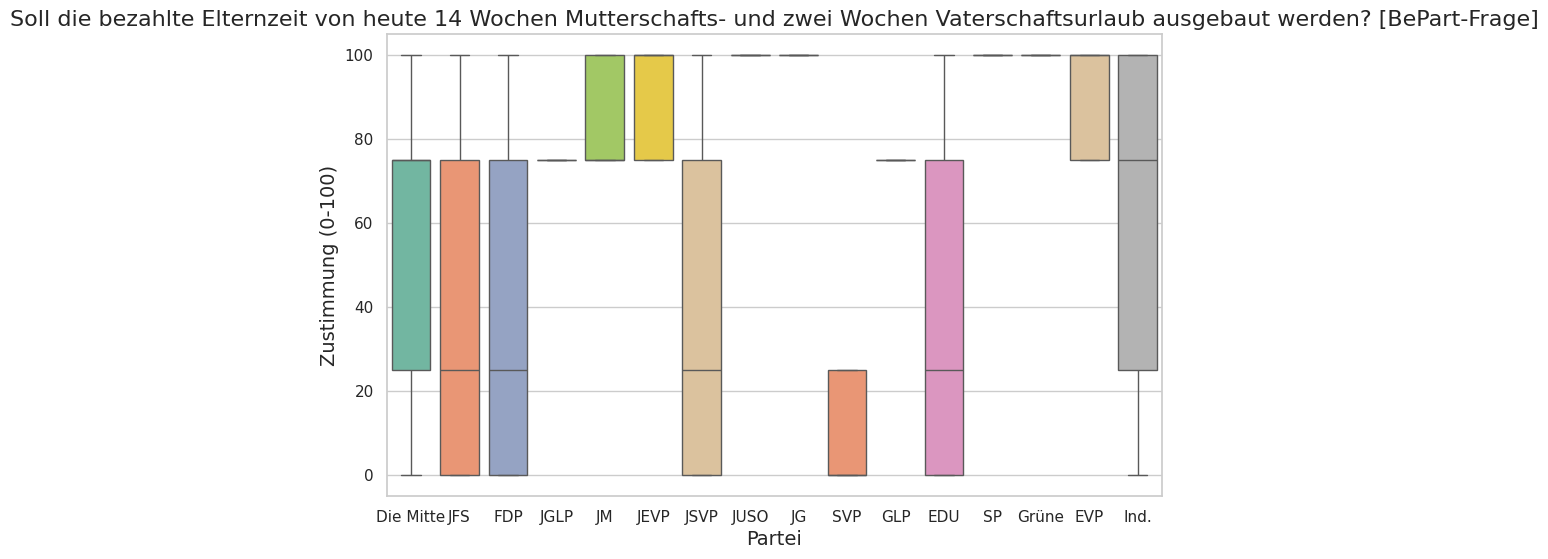

In [5]:
plt.figure(figsize=(10, 6)) # Definiere die Größe des Plots
sns.set_theme(style="whitegrid") # Hintergrund mit Gitternetzlinien

# Parteikürzel auf der x-Achse, Zustimmung auf der y-Achse
sns.boxplot(x='partyAbbreviation', y='answer', data=filtered_answer_df, palette='Set2', showfliers=False)

# Achsenbeschriftung und Titel
plt.title(frage, fontsize=16)
plt.xlabel("Partei", fontsize=14)
plt.ylabel("Zustimmung (0-100)", fontsize=14)

# Ausgabe des Plots
plt.show()

# Abweichler


## Teil 1: Grösste Abweichler finden


In [6]:
import pandas as pd # Für tabellenartige Daten
import numpy as np # Für numerische Operationen

df = pd.DataFrame(candidates) # Daten in ein Pandas DataFrame umwandeln (für die bessere Handhabung)

expanded_answers = []
for idx, row in df.iterrows(): # Iteriere über alle Kandidierenden
    for answer in row["answers"]: # Iteriere über alle Antworten
        expanded_answers.append({ 
            "candidate_id": row["id"],
            "firstname": row["firstname"],
            "lastname": row["lastname"],
            "partyAbbreviation": row["partyAbbreviation"],
            "questionId": answer["questionId"],
            "answer": answer["value"]
        })

answers_df = pd.DataFrame(expanded_answers)
print(answers_df)

       candidate_id  firstname lastname partyAbbreviation questionId  answer
0             56233    Antonio    Abate         Die Mitte      32218      75
1             56233    Antonio    Abate         Die Mitte      32261      75
2             56233    Antonio    Abate         Die Mitte      32214       0
3             56233    Antonio    Abate         Die Mitte      32223       0
4             56233    Antonio    Abate         Die Mitte      32224      25
...             ...        ...      ...               ...        ...     ...
372220        53495  Dominique  Zygmont               FDP      32285      50
372221        53495  Dominique  Zygmont               FDP      32284      50
372222        53495  Dominique  Zygmont               FDP      32225      25
372223        53495  Dominique  Zygmont               FDP      32234      75
372224        53495  Dominique  Zygmont               FDP      32235     100

[372225 rows x 6 columns]


In [7]:
# Berechnet den Durchschnitt der Antworten für jede Partei und jede Frage
party_averages = answers_df.groupby(['partyAbbreviation', 'questionId'])['answer'].mean().reset_index() # Gruppiert die Daten nach Partei und Frage und berechnet den Durchschnitt
party_averages.rename(columns={'answer': 'party_avg'}, inplace=True) # Benennt die Spalte "answer" in "party_avg" um
print(party_averages)

     partyAbbreviation questionId   party_avg
0                   AL      32214    2.419355
1                   AL      32215  100.000000
2                   AL      32216   77.419355
3                   AL      32217    0.806452
4                   AL      32218   99.193548
...                ...        ...         ...
3820               neo      32284   50.000000
3821               neo      32285   50.000000
3822               neo      32286   50.000000
3823               neo      32287   50.000000
3824               neo      32288   50.000000

[3825 rows x 3 columns]


In [8]:
# Fügt den durchschnittlichen Partei-Antworten zu den individuellen Antworten hinzu
answers_with_avg = pd.merge(answers_df, party_averages, on=['partyAbbreviation', 'questionId'])

# Berechnet die Abweichung der Antwort von der durchschnittlichen Parteiantwort
answers_with_avg['deviation'] = np.abs(answers_with_avg['answer'] - answers_with_avg['party_avg']) # Berechnet die absolute Abweichung

# Berechnet die durchschnittliche Abweichung für jeden Kandidaten
candidate_deviations = answers_with_avg.groupby(['candidate_id', 'firstname', 'lastname', 'partyAbbreviation'])['deviation'].mean().reset_index() # Gruppiert die Daten nach Kandidierenden und berechnet den Durchschnitt der Abweichungen

Nun folgt noch die schöne Formatierung der Tabelle sowie die Ausgabe.


In [9]:
# Nun Formattieren wir die Daten für die Ausgabe
# Zuerst benennen wir die Spalten auf Deutsch um
candidate_deviations.rename(columns={
    'candidate_id': 'ID',
    'firstname': 'Vorname',
    'lastname': 'Nachname',
    'partyAbbreviation': 'Partei',
    'deviation': 'Abweichung'
}, inplace=True)

candidate_deviations = candidate_deviations[candidate_deviations['Partei'] != 'Ind.']  # Die unabhängigen Kandidaten entfernen

candidate_deviations.set_index('ID', inplace=True) # Zur Formattierung der Tabelle (1. Spalte)


# Sortiert die Kandidaten nach der durchschnittlichen Abweichung (absteigend)
most_dissenting_candidates = candidate_deviations.sort_values(by='Abweichung', ascending=False)

display_df = most_dissenting_candidates.reset_index() # Nummeriert von 0 an die Resultate durch
display_df.index += 1   # Nummerierung soll bei 1 beginnen


# Ausgabe der ersten 20 Kandidierenden
print(display_df.head(20))

       ID      Vorname      Nachname     Partei  Abweichung
1   53854        Simon    Hostettler       JEVP   45.566833
2   55472         Marc     Allenbach        GLP   44.780694
3   55838        Cyril          Nobs        SVP   44.744964
4   58044       Moreno       Colombo        FDP   44.418586
5   53947        Savio     Michellod        FDP   43.711111
6   56607         Luka     Vojinovic  Die Mitte   43.597932
7   54102        Laure    Vouillamoz        JFS   43.379237
8   56177  Hans Rudolf         Lüthi  Die Mitte   43.125507
9   59448       Carola        Barchi        FDP   43.051313
10  57652        Dusan       Konatar        SVP   42.951734
11  58106       Nicole       Giudici         JM   42.863563
12  59249        Erika       Strobel  Die Mitte   42.817681
13  57478          Urs       Schärer  engagiert   42.806154
14  58129       Giulia     Petrimpol         JM   42.795287
15  55909        Alois        Felder  Die Mitte   42.627382
16  56768       Jeremy        Kuwegu    

## Teil 2: Abweichler nach Partei


In [10]:
import matplotlib.pyplot as plt # Für die Visualisierung
import seaborn as sns # Für die Visualisierung

def categorize_deviation(dev): # Funktion zur Kategorisierung der Abweichung
    if dev > 30:
        return "High Deviator"
    else:
        return "Aligned"

# Abweichler-Kategorisierung hinzufügen
candidate_deviations['Abweichler-Grad'] = candidate_deviations['Abweichung'].apply(categorize_deviation) # Fügt eine neue Spalte für die Kateogrisierung hinzu

# Anzahl Mitglieder pro Partei und Abweichler-Grad zählen
deviator_stats = candidate_deviations.groupby(['Partei', 'Abweichler-Grad']).size().unstack(fill_value=0)
print(deviator_stats)

Abweichler-Grad    Aligned  High Deviator
Partei                                   
AL                      31              0
Aufrecht                36              9
Avanti                   3              0
BastA!                   6              0
CSP                      1              0
DA                       5              0
DAL                      2              0
Die Mitte              581            109
EAG-LUP                 29              0
EDU                    136             21
EVP                    199             40
FDP                    333             30
Forum Alternativo        3              0
GLP                    557             19
Grüne                  347              4
Grüne Panther            5              0
JA                       6              0
JBastA                   4              0
JEVP                    75              5
JFS                    175             26
JG                     210              1
JGLP                   175        

/tmp/ipykernel_162125/578854806.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_parties.index, y=top_10_parties['% High Deviators'], palette='Set2') # Erstellt das Balkendiagramm


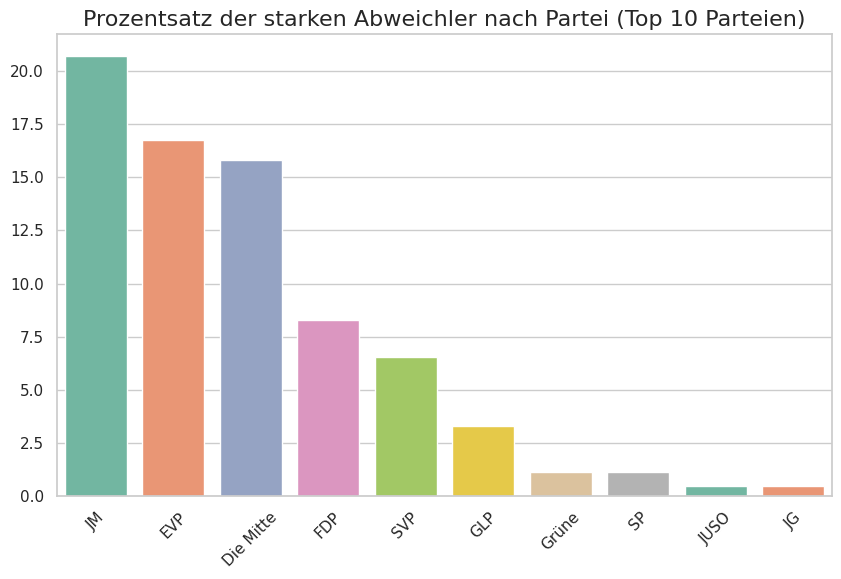

In [11]:
# Anzahl Mitglieder pro Partei hinzufügen
deviator_stats['Gesamt'] = deviator_stats.sum(axis=1) # Summiert die Anzahl der Mitglieder pro Partei (summiert die Zeile)

# Anteil der starken Abweichler berechnen
deviator_stats['% High Deviators'] = (deviator_stats['High Deviator'] / deviator_stats['Gesamt']) * 100 

# Sortiert die Parteien nach der Anzahl der Mitglieder und behält die Top 10
top_10_parties = deviator_stats.sort_values(by='Gesamt', ascending=False).head(10)

# Sortierung nach dem Prozentsatz der starken Abweichler
top_10_parties = top_10_parties.sort_values(by='% High Deviators', ascending=False)

# Erstellung des Balkendiagramms
plt.figure(figsize=(10, 6)) # Definiert die Größe des Plots
sns.barplot(x=top_10_parties.index, y=top_10_parties['% High Deviators'], palette='Set2') # Erstellt das Balkendiagramm
plt.title("Prozentsatz der starken Abweichler nach Partei (Top 10 Parteien)", fontsize=16) # Titel des Plots
plt.xlabel("") # Beschriftung der x-Achse
plt.ylabel("") # Beschriftung der y-Achse
plt.xticks(rotation=45) # Rotiert die x-Achsenbeschriftung um 45 Grad
plt.show() # Ausgabe des Plots